1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.
2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)
6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
import os
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

import warnings
from statsmodels.tsa.arima_model import ARIMA
from random import random


In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
data_w = data.resample('W').mean()
data_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


In [4]:
data_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 866 entries, 2002-01-06 to 2018-08-05
Freq: W-SUN
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PJME_MW          866 non-null    float64
 1   year             866 non-null    float64
 2   month            866 non-null    float64
 3   dayofmonth       866 non-null    float64
 4   quarter          866 non-null    float64
 5   dayofyear        866 non-null    float64
 6   weekofyear       866 non-null    float64
 7   dayofweek        866 non-null    float64
 8   hour             866 non-null    float64
 9   is_holiday       866 non-null    float64
 10  is_prev_holiday  866 non-null    float64
 11  is_next_holiday  866 non-null    float64
dtypes: float64(12)
memory usage: 88.0 KB


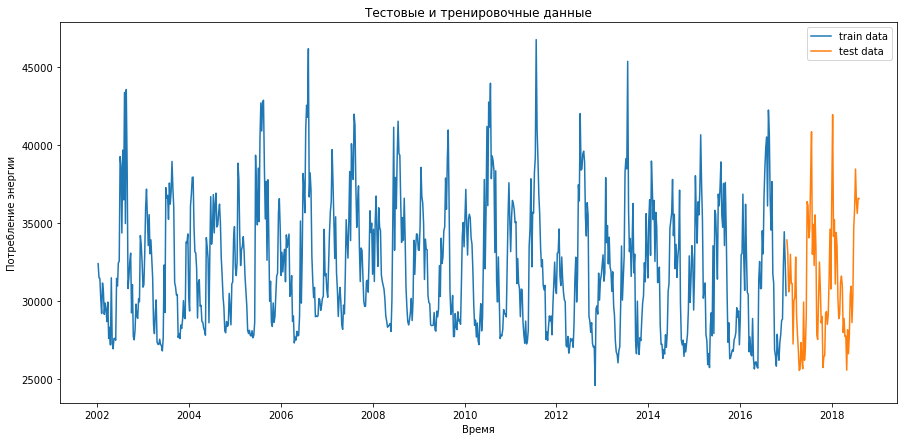

In [5]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()

# сделаем примеры и модель 
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train_b, test_b = split_data_b( data_w, '01-01-2017')

X_train_b = train_b.iloc[:-1,:]
y_train_b = train_b[data_w.columns[0]].values[1:]
X_test_b = test_b.iloc[:-1,:]
y_test_b = test_b[data_w.columns[0]].values[1:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(train_b.index.get_level_values('Date'),train_b[data_w.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Date'),test_b[data_w.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

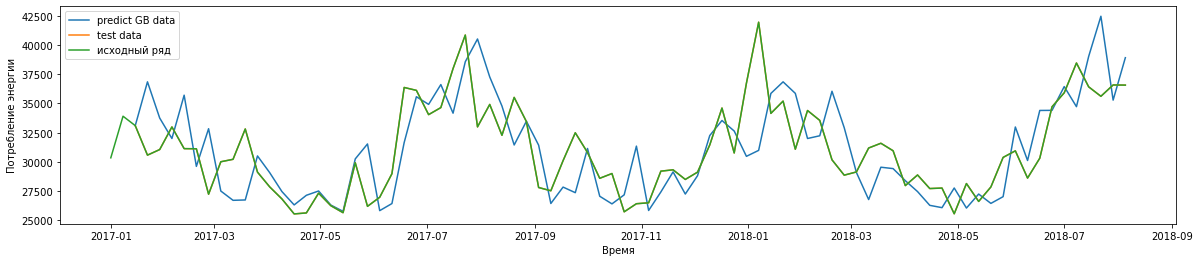

ошибка градиентного бустинга :   7.620668146388292 %


In [8]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test_b.index[1:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[1:],y_test_b, label='test data')
plt.plot(data_w.loc['2017-01-01':].index, data_w.loc['2017-01-01':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

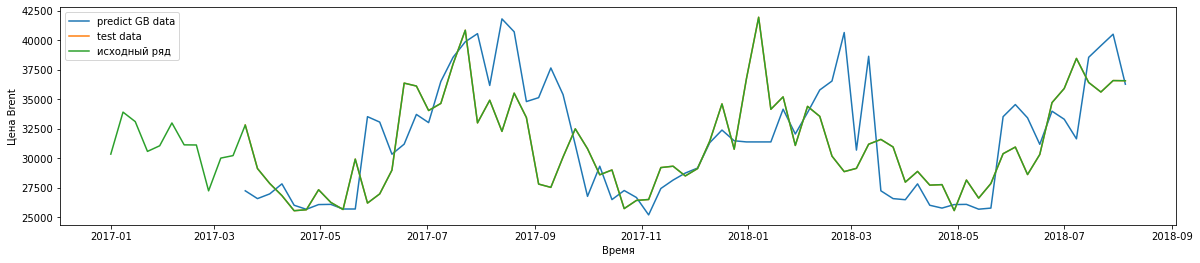

ошибка градиентного бустинга :   9.308902618696388 %


In [10]:
h=10
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[data_w.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[data_w.columns[0]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(data_w.loc['2017-01-01':].index, data_w.loc['2017-01-01':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')